# Can you predict which NBA players will make the "All-Star" team?

## Part one: Clean the data

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from featurewiz import featurewiz

Imported featurewiz: advanced feature engg and selection library. Version=0.0.42
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


#### Load 'player_data.csv' 

In [2]:
df = pd.read_csv('player_data.csv')


#### Drop the first column

In [3]:
df.drop(df.columns[[0]], axis=1,inplace=True )

#### Remove null values from "Players" column
*I understood this request as "Remove rows where the Player column is null"*

In [4]:
df.Player.isnull().sum()

67

In [5]:
df.dropna(subset=['Player'], inplace=True)

#### Replace null values with 0's in the '3P%' column

In [6]:
df['3P%'].fillna(0, inplace=True)

#### Remove rows for players who started their careers before the 1980 season

*Reassignation faster than drop*

In [7]:
df = df[df.Year >= 1980]


#### Load in the 'all_star_appearances.pickle' file and use this data to create a column called 'all_star' that indicates whether or not a player made the All-Star team for a given year
- This file is a dictionary in which the keys are players who've made an All-Star team in their careers
- The values are all the years that the corresponding player made an All-Star team

#### Make sure this column is binary where 1 = Made All-Star team, and 0 = Did not make All-Star team

*Assumption: For the purpose of this exercise I will assume the names on the dictionary keys*
*and the names on the "Player" column match, however in a production scenario a better solution would be to use edit distance to calculate string similarity*
*avoiding the possibility of small string differences resulting in no match. This can be done with Levenshtein or SequenceMatcher*

In [8]:
# Pickle to DF
allstar_df = pd.read_pickle('all_star_appearances.pickle')
allstar_df = pd.DataFrame(allstar_df.items(), columns=['Player', 'list_years'])
# Clean name and merge
df['Player'] = df['Player'].str.strip('*')
final_df = df.merge(allstar_df, on='Player', how='left')
# Create all_star column
final_df.list_years.fillna({i: [0] for i in final_df.index}, inplace=True)
final_df['all_star'] = [int(x[0] in x[1]) for x in final_df[['Year', 'list_years']].values.tolist()]
final_df.drop('list_years', axis=1, inplace=True)

## Part 2: Exploratory data analysis

#### Generate descriptive stats for the features

In [9]:
final_df.describe(include='all')


,Year,Player,Pos,Age,Tm,G,PER,TS%,ORB%,DRB%,...,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS,all_star
count,18927.000000,18927,18927,18927.000000,18927,18927.000000,18922.000000,18851.000000,18922.000000,18922.000000,...,18810.000000,18839.000000,18182.000000,18927.000000,18927.000000,18927.000000,18927.000000,18927.000000,18927.000000,18927.000000
unique,NaN,2833,16,NaN,41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Eddie Johnson,PF,NaN,TOT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,31,3945,NaN,1636,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2000.272415,NaN,NaN,26.838326,NaN,49.639510,12.395714,0.503862,6.153715,13.741587,...,0.457184,0.464085,0.721709,203.935066,110.585513,38.771332,24.171818,72.570613,486.034184,0.049453
std,10.691977,NaN,NaN,3.999546,NaN,26.693379,6.200326,0.094507,4.957866,6.607566,...,0.100017,0.098349,0.147018,202.431683,137.328298,37.829930,36.471577,66.602288,479.419028,0.216818
min,1980.000000,NaN,NaN,18.000000,NaN,1.000000,-90.600000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1992.000000,NaN,NaN,24.000000,NaN,26.000000,9.700000,0.473000,2.500000,8.900000,...,0.423000,0.433000,0.660000,46.000000,17.000000,9.000000,3.000000,17.000000,94.000000,0.000000
50%,2001.000000,NaN,NaN,26.000000,NaN,55.000000,12.700000,0.516000,5.300000,12.800000,...,0.467000,0.475000,0.750000,145.000000,61.000000,28.000000,11.000000,54.000000,338.000000,0.000000
75%,2010.000000,NaN,NaN,30.000000,NaN,75.000000,15.600000,0.551000,9.000000,18.100000,...,0.503000,0.510000,0.813000,295.000000,151.000000,58.000000,29.000000,110.000000,750.000000,0.000000


#### Create a corr map of the features

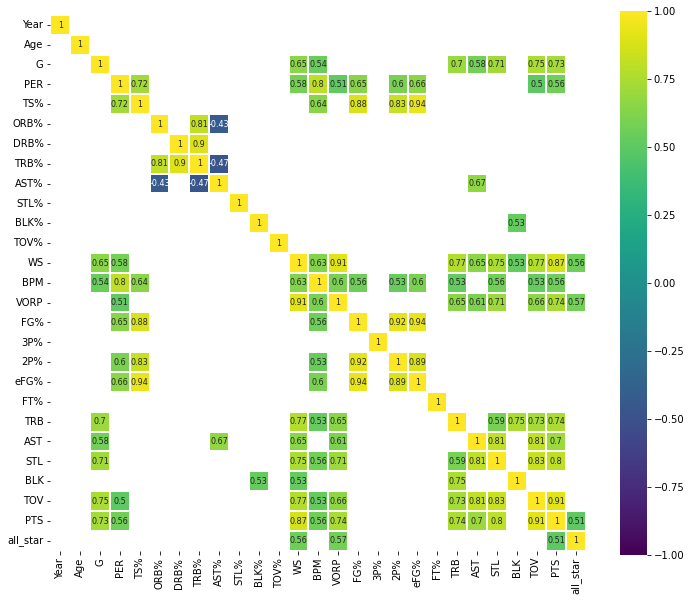

In [10]:
corr = final_df.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

#### Graph the distibution of the 'Age' feature

<AxesSubplot:>

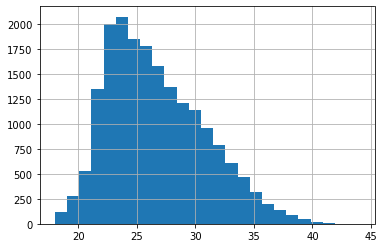

In [11]:
final_df.Age.hist(bins=25)

## Part 3: Classification

### Build a classifier that predicts whether or not a player makes an All-Star team based on their stats for that season
*Trying two different methods to compare accuracy*

### Method 1: Manual Feature Selection
*Better said: no feature selection!*

In [12]:
def model_generator(df, features, test_size=0.2):
    # Separating target from features
    Y = df['all_star']
    X = df[features]

    # Dealing with categorical variables and imputing missing data
    X = pd.get_dummies(X, drop_first=True)
    X = X.fillna(X.mean())
    x_features = X.columns.tolist()

    # Standardizing data and separting training from test
    X_scaled =  StandardScaler().fit_transform(X)
    X_train, X_valid, y_train, y_valid = train_test_split(X_scaled,Y,test_size = test_size,stratify=Y, random_state=1)

    # Model creating and fit
    classifier = RandomForestClassifier()
    classifier.fit(X_train,y_train)

    # make prediction
    preds = classifier.predict(X_valid)
    # check performance
    accuracy = accuracy_score(preds,y_valid)

    print('Features: ' + str(len(features)))
    print('Test size: ' + str(test_size))
    print('Accuracy: ' + str(accuracy))

    print('\nMost Important Features')
    feature_importance = dict(zip(x_features[:10], classifier.feature_importances_[:10]))
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
    for k, v in feature_importance.items():
        print(str(k) + ' ' + str(v))

    print('\nLeast Important Features')
    feature_importance = dict(zip(x_features[-10:], classifier.feature_importances_[-10:]))
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1])}
    for k, v in feature_importance.items():
        print(str(k) + ' ' + str(v))

In [13]:
features = final_df.drop(['Player', 'all_star'],axis=1).columns.tolist()
model_generator(final_df, features, test_size=0.15)

Features: 28
Test size: 0.15
Accuracy: 0.9725352112676057

Most Important Features
PER 0.09667145257781351
G 0.023810939483916584
AST% 0.022647375592154347
TS% 0.020520137622427225
DRB% 0.020351825140596514
Year 0.019421470408706332
TRB% 0.01837880867025597
ORB% 0.017881258966914927
Age 0.01715110821452894
STL% 0.0147978254005762

Least Important Features
Tm_VAN 2.7426351269463012e-05
Tm_SDC 0.00031544399872674117
Tm_WSB 0.0006265950462622366
Tm_WAS 0.0006800643763705403
Tm_TOR 0.0007382966051718982
Tm_UTA 0.0008187223625442199
Tm_SEA 0.0008423506036015118
Tm_SAC 0.0008844673433055457
Tm_TOT 0.001052022038107357
Tm_SAS 0.0011296928046968147


### Method 2: Featurewiz

Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Loading train data...
Shape of your Data Set loaded: (18927, 30)
Loading test data...
    Filename is an empty string or file not able to be loaded
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    29 Predictors classified...
        2 variable(s) will be ignored since they are ID or low-information variables
No GPU active on this device
    Running XGBoost using CPU parameters
Removing 2 columns from further processing since ID or low information variables
    columns removed: ['Player', 'Tm']
    After removing redundant variables from further processing, features left = 27
#### Single_Label Binary_Classification Feature Selection Started ####
Searching for highly correlated variables from 26 variables using SULOV method
#####  SULOV : Searching for Uncorrelated List Of Variables (t

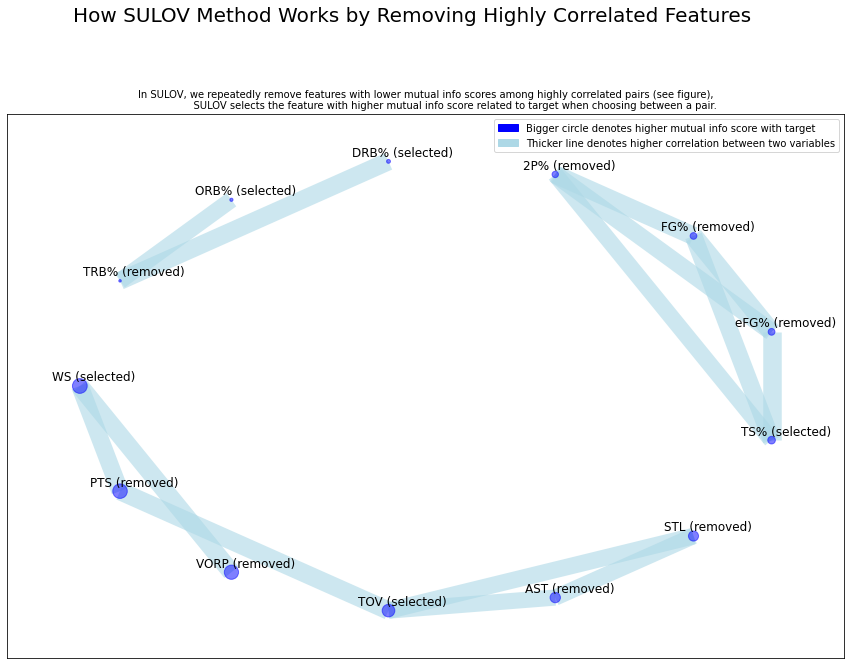

In [14]:
target = 'all_star'

features, train = featurewiz(final_df, target, corr_limit=0.8, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")


print(features)

In [15]:
model_generator(train, features, test_size=0.15)

Features: 18
Test size: 0.15
Accuracy: 0.972887323943662

Most Important Features
WS 0.21381725303302826
PER 0.15937185967388237
TOV 0.12316174669191997
BPM 0.08590222618764573
TRB 0.051382197997538716
G 0.03620302131551696
TOV% 0.03371320702492625
Year 0.0305074688002104
Age 0.02693608417035829
Pos 0.009201059286697743

Least Important Features
BLK% 0.02131102941216959
3P% 0.024193274932011608
ORB% 0.026622753151506254
FT% 0.02866964650021206
DRB% 0.029414379043947093
BLK 0.032347296026403585
TS% 0.033565571524127286
AST% 0.03367992522789784
TOV% 0.03371320702492625
TRB 0.051382197997538716


#### Marginal improvement from no feature selection
#### I will stop here however:
#### - Proper feature selection and engineering is lacking, more time and knowledge about the field would be necessary.
#### - There are other clasifiers and hyper-parameters that can be tried, a good solution would be to iterate through all possibilities and compare accuracy (Either manually or with GridSearchCV)
#### - Such a high accuracy suggests the possibility of overfitting, would be good to try with new or slightly different data.